# Makemore - Bigram model

Given a character predict the next one in the sequence using a lookup table of counts from the data. This is called a **bigram model** because we are looking at pairs of characters. We will build a character-level autoregressive model to generate baby names using a model built using [a dataset of popular baby names](https://www.ssa.gov/oact/babynames/).

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

seed = 1234

## Look at the data

In [2]:
names = open('names.txt', 'r').read().splitlines()

In [3]:
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
print(f"Total number of names: {len(names):,}")
print(f"Shortest name: '{min(names, key=len)}' containing {len(min(names, key=len))} characters")
print(f"Longest name: '{max(names, key=len)}' containing {len(max(names, key=len))} characters")

Total number of names: 32,033
Shortest name: 'an' containing 2 characters
Longest name: 'muhammadibrahim' containing 15 characters


Each name in the dataset gives us the following statistically useful information for generating novel names:
1. **Initiation**: The likely first character to start a name.
2. **Sequence generation**: The likely next character given all the characters in the name so far.
3. **Termination**: The likely last character in names, after which the name ends.

## Build the bigram counts table

In [5]:
bigram_counts = {}

for name in names:
    # start token - list of characters - end token
    chars = ['.'] + list(name) + ['.']

    # a 2-character window sliding through the names
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        if bigram not in bigram_counts:
            bigram_counts[bigram] = 1
        else:
            bigram_counts[bigram] += 1

In [6]:
# top-10 most frequent bigrams
sorted(bigram_counts.items(), key=lambda kv: kv[1], reverse=True)[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

In [7]:
# vocabulary of all characters
# '.' is a special token that indicates start/stop token for names
vocab = ['.'] + sorted(set([char for name in names for char in name]))
char_to_ix = {char: i for i, char in enumerate(vocab)}
ix_to_char = {i: char for i, char in enumerate(vocab)}
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [8]:
# store the bigram counts in a lookup table
# rows: first character
# columns: second character
# values: how often does the second character follow the first character

bigram_lookup = torch.zeros(len(vocab), len(vocab), dtype=torch.int32)
for bigram, count in bigram_counts.items():
    char1, char2 = bigram
    char1_ix, char2_ix = char_to_ix[char1], char_to_ix[char2]
    bigram_lookup[char1_ix, char2_ix] = count

(-0.5, 26.5, 26.5, -0.5)

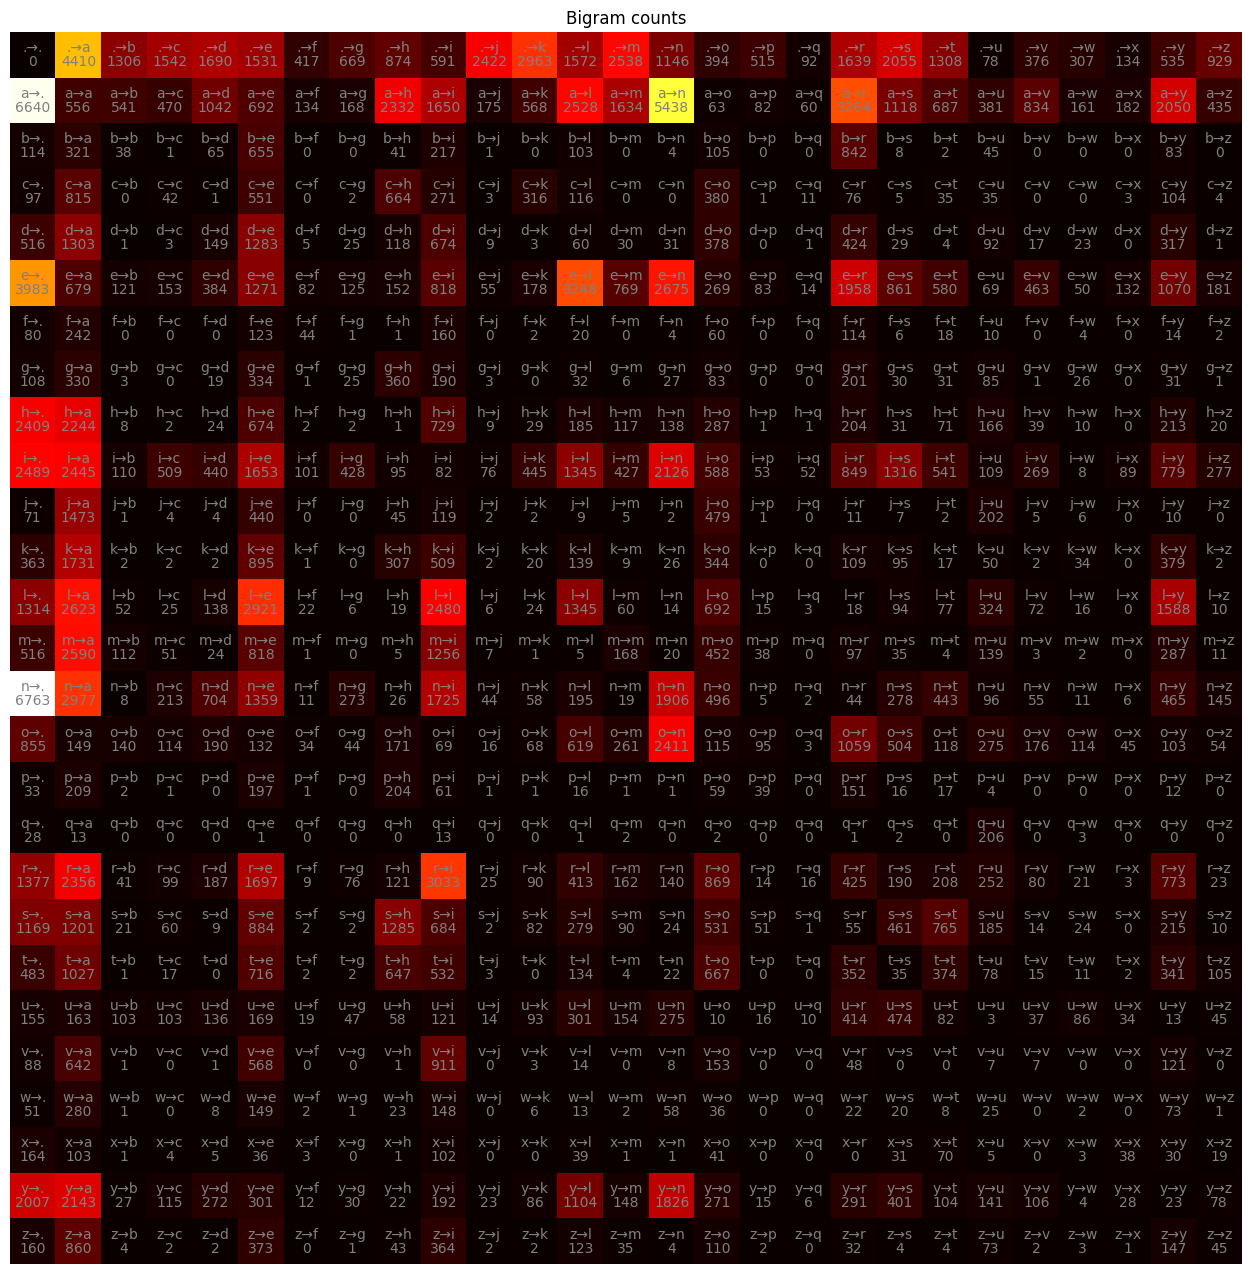

In [9]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(16,16))
plt.imshow(bigram_lookup, cmap='hot')

for from_ix, from_char in enumerate(vocab):
    for to_ix, to_char in enumerate(vocab):
        label = f"{from_char}→{to_char}"
        plt.text(to_ix, from_ix, label, ha='center', va='bottom', color='gray')
        plt.text(to_ix, from_ix, bigram_lookup[from_ix, to_ix].item(), ha='center', va='top', color='gray')

plt.title('Bigram counts')
plt.axis('off')

## Sample new names from the counts table

In [10]:
# convert counts into probabilities
bigram_probs = bigram_lookup.float() + 1  # smoothing zero counts
bigram_probs /= bigram_probs.sum(dim=1, keepdim=True)
bigram_probs

tensor([[3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02],
        [1.9583e-01, 1.6425e-02, 1.5983e-02, 1.3889e-02, 3.0756e-02, 2.0435e-02,
         3.9809e-03, 4.9835e-03, 6.8796e-02, 4.8685e-02, 5.1899e-03, 1.6779e-02,
         7.4575e-02, 4.8213e-02, 1.6039e-01, 1.8872e-03, 2.4475e-03, 1.7988e-03,
         9.6279e-02, 3.2997e-02, 2.0288e-02, 1.1264e-02, 2.4623e-02, 4.7771e-03,
         5.3963e-03, 6.0480e-02, 1.2857e-02],
        [4.3039e-02, 1.2051e-01, 1.4596e-02, 7.4850e-04, 2.4701e-02, 2.4551e-01,
         3.7425e-04, 3.7425e-04, 1.5719e-02, 8.1587e-02, 7.4850e-04, 3.7425e-04,
         3.8922e-02, 3.7425e-04, 1.8713e-03, 3.9671e-02, 3.7425e-04, 3.7425e-04,
         3.1549e-

In [11]:
rng = torch.Generator().manual_seed(seed)

In [12]:
num_names = 10

for _ in range(num_names):
    name = []
    ix = 0
    while True:
        ix = torch.multinomial(bigram_probs[ix], num_samples=1, replacement=True, generator=rng).item()
        name.append(ix_to_char[ix])
        if ix == 0:
            break
    print(''.join(name))

k.
melyn.
dahileiebrverar.
ynakhoyin.
treureleovo.
lis.
byuma.
c.
thegh.
ysady.


## Evaluate the quality of the model
- A good model would assign probabilities of `1.0` for each bigram present in the training dataset. A random guess would be to assign uniform probabilities of $\frac{1}{27} = 0.037$.
- **Likelihood**: The likelihood of the training dataset is the product of each bigram probability in the dataset. A good model of the training dataset would assign very high likelihood for the training dataset. So, good models try to maximize the likelihood of the training data.
$$
\mathcal{L}(D) = \prod_{t=1}^{|D|} Pr(x_{t+1}|x_{t})
$$
- **Log-likelihood**: Log-likelihood is preferred here because a large number of products of values 0-1 may result in an underflow. Instead of multiplying the probabilities, add the logarithms. Log likelihood is a monotonic transformation of the input. $\log(0)\approx-\infty$ and $\log(1)=0$. Good models try to maximize the log-likelihood of the training data.
$$
\mathcal{L}(D) = \sum_{t=1}^{|D|} \log Pr(x_{t+1}|x_{t})
$$
- **Negative log-likelihood**: Convert log likelihood into a loss function, where lower is better. Currently, in log-likelihood, higher is better. Best negative log-likelihood is 0. Higher values correspond to worse models. You can take the average to get the normalized negative log-likelihood. Good models try to maximize the normalized negative log-likelihood of the training data.

In [13]:
log_likelihood = 0.0
n = 0

for name in names:
    # start token - list of characters - end token
    chars = ['.'] + list(name) + ['.']

    # a 2-character window sliding through the names
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        char1_ix, char2_ix = char_to_ix[char1], char_to_ix[char2]
        prob = bigram_probs[char1_ix, char2_ix]
        log_likelihood += torch.log(prob)
        n += 1
print(f"Log-likelihood of the training dataset: {log_likelihood:.4f}")
neg_log_likelihood = -log_likelihood
print(f"Negative log-likelihood of the training dataset: {neg_log_likelihood:.4f}")
print(f"Normalized negative log-likelihood of the training dataset: {neg_log_likelihood / n:.4f}")

Log-likelihood of the training dataset: -559951.5625
Negative log-likelihood of the training dataset: 559951.5625
Normalized negative log-likelihood of the training dataset: 2.4544


In [14]:
def nll_of_name(name):
    log_likelihood = 0.0
    n = 0
    chars = ['.'] + list(name) + ['.']

    # a 2-character window sliding through the name
    for char1, char2 in zip(chars, chars[1:]):
        char1_ix, char2_ix = char_to_ix[char1], char_to_ix[char2]
        prob = bigram_probs[char1_ix, char2_ix]
        log_likelihood += torch.log(prob)
        n += 1

    return -log_likelihood / n

In [15]:
name = 'kevin'  # likely name
print(f"Normalized negative log-likelihood of name {name}: {nll_of_name(name):.4f}")

Normalized negative log-likelihood of name kevin: 2.0110


In [16]:
name = 'xkevin'  # unlikely name
print(f"Normalized negative log-likelihood of name {name}: {nll_of_name(name):.4f}")

Normalized negative log-likelihood of name xkevin: 3.1057


## Modeling the counts table with neural networks

### Walkthrough

In [17]:
# 1. Training dataset: given a character, predict the next character
xs, ys = [], []

for name in names[:1]:
    # start token - list of characters - end token
    chars = ['.'] + list(name) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        xs.append(char_to_ix[char1])
        ys.append(char_to_ix[char2])
        print(f"{char1}→{char2}")

xs = torch.tensor(xs)
ys = torch.tensor(ys)

.→e
e→m
m→m
m→a
a→.


In [18]:
print(''.join(map(lambda c: ix_to_char[c], xs.tolist())))
print(''.join(map(lambda c: ix_to_char[c], ys.tolist())))

.emma
emma.


In [19]:
# 2. One-hot encode the tokens
x_enc = F.one_hot(xs, num_classes=len(vocab)).float()
print(x_enc.shape)

torch.Size([5, 27])


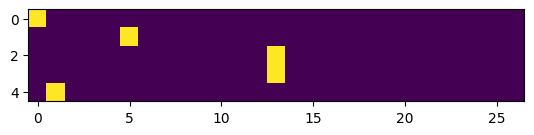

In [20]:
plt.imshow(x_enc)

In [21]:
# 3. Forward pass
print(x_enc.shape)

rng = torch.Generator().manual_seed(seed)
w = torch.randn((len(vocab), len(vocab)), generator=rng)
print(w.shape)

logit = x_enc @ w
print(logit.shape)

torch.Size([5, 27])
torch.Size([27, 27])
torch.Size([5, 27])


In [22]:
logit[0]  # logits or log-counts (range: -inf to inf)

tensor([-0.1117, -0.4966,  0.1631, -0.8817,  0.0539,  0.6684, -0.0597, -0.4675,
        -0.2153,  0.8840, -0.7584, -0.3689, -0.3424, -1.4020,  0.3206, -1.0219,
         0.7988, -0.0923, -0.7049, -1.6024,  0.2891,  0.4899, -0.3853, -0.7120,
        -0.1706, -1.4594,  0.2207])

In [23]:
# e**x: (-inf to inf) => (0 to inf)
# negative numbers => (0 to 1); positive numbers => (1 to inf)
counts = logit.exp()
counts[0]  # similar to counts per character

tensor([0.8943, 0.6086, 1.1771, 0.4141, 1.0554, 1.9511, 0.9421, 0.6266, 0.8063,
        2.4205, 0.4684, 0.6915, 0.7101, 0.2461, 1.3780, 0.3599, 2.2229, 0.9118,
        0.4941, 0.2014, 1.3352, 1.6321, 0.6803, 0.4906, 0.8431, 0.2324, 1.2469])

In [24]:
# counts to probabilities
probs = counts / counts.sum(dim=1, keepdim=True)
print(probs[0])
print(probs[0].sum())

tensor([0.0357, 0.0243, 0.0470, 0.0165, 0.0421, 0.0779, 0.0376, 0.0250, 0.0322,
        0.0967, 0.0187, 0.0276, 0.0284, 0.0098, 0.0550, 0.0144, 0.0888, 0.0364,
        0.0197, 0.0080, 0.0533, 0.0652, 0.0272, 0.0196, 0.0337, 0.0093, 0.0498])
tensor(1.0000)


In [25]:
probs.shape

torch.Size([5, 27])